In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

%load_ext autoreload
%autoreload 2
from trader.utils import *
from trader.tradertk import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [237]:
# get_x??

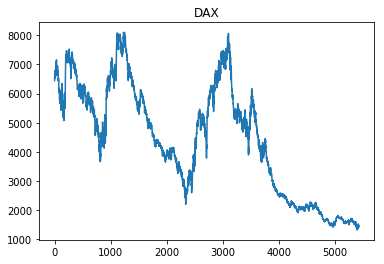

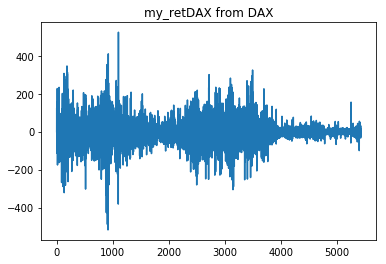

In [238]:
with open('data/retDAX.txt', 'r') as f:
    tmp = f.read()
    
retDAX = list(map(lambda x: float(x), tmp.split()))

with open('data/DAX.txt', 'r') as f:
    tmp = f.read()
    
DAX = list(map(lambda x: float(x), tmp.split()))

plt.plot(DAX)
plt.title('DAX')
plt.show()

# plt.plot(retDAX)
# plt.title('retDAX')
# plt.show()

# print('std(retDAX): ', np.std(retDAX))

tmp = [DAX[0]]
for x in retDAX:
    tmp.append(tmp[-1] + x)

# plt.plot(tmp)
# plt.title('DAX from Returns retDAX')
# plt.show()

my_retDAX = [0]
for i in range(1, len(DAX)):
    my_retDAX.append(DAX[i] - DAX[i-1])
    
plt.plot(my_retDAX)
plt.title('my_retDAX from DAX')
plt.show()

In [239]:
len(my_retDAX)

5426

# Here goes the main part:

# Experimenting....

In [262]:
%%time
M = 10  # The number of time series inputs to the trader.
w = np.random.uniform(0.0, 1.0, M+3)  # Weights initialization.

miu = 1  # Maximum possible number of shares per transaction.
delta = 0.0006  # Cost for a transaction at period t.
                # 0.0006 is default value in Moscow

maxT = 500
num_iter = 100
learning_rate = 0.01
# start with 0.01 and change it after every epoch this way --> Lr_current = Lr_0*(n_all_epochs-cur_epoch)/n_all_epochs

# predict with dynamic window - 50 predicted and learn on 100 prev real data


sums_rew = []
last_srs = []

for iterr in range(1):
    X = build_x(maxT, M, my_retDAX, w)

    F = get_trader_func(X, M)

    Rewards, s_ratio = get_rewards(maxT, my_retDAX, F, miu, delta)
    
    print(len(Rewards))

#     dFt = get_grad_F_w(maxT, X, w)

#     grad = get_grad_S_w(maxT, Rewards, my_retDAX, F, miu, delta, dFt)

#     ##################
#     # Weights update.
#     ##################
#     w_old = w.copy()
#     w += learning_rate * grad

#     sums_rew.append(sum(Rewards)) 
#     last_srs.append(s_ratio)

# plt.plot(last_srs)
# plt.title("Sharpe's Ratio through iterations")
# plt.xlabel('iteration')
# plt.show()

500
CPU times: user 6.63 ms, sys: 795 µs, total: 7.42 ms
Wall time: 7.01 ms
